### Interpret Results

In [56]:
from notebook_utils import modify_sys_path, get_src_dir_path

modify_sys_path()

In [59]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np

from src.dataset import load_dataset


In [13]:
data_dir = 'datasets_toy_regression/linear_regression_1'

train, test, labels = load_dataset(data_path=get_src_dir_path(data_dir), data_type="toy_regression", data_split_seed=0)

Text(0.5, 1.0, 'Train Data')

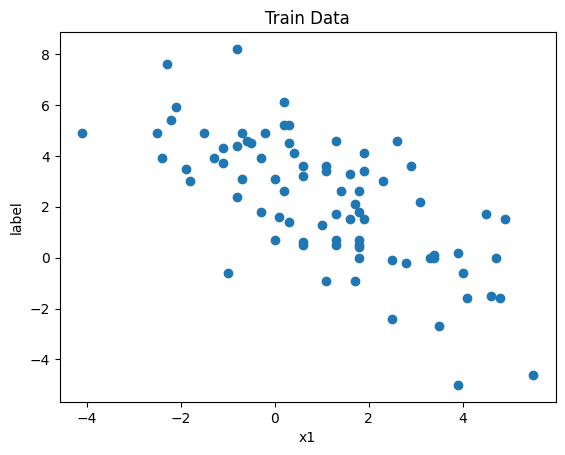

In [14]:
fig, ax = plt.subplots()

ax.scatter(train["x1"], train["label"])
ax.set_xlabel("x1")
ax.set_ylabel("label")
ax.set_title("Train Data")

### Hypothesis Testing

In [5]:
from src.prompt import ToyRegressionPrompt
from src.utils import ToyClassificationUtils, extract
from src.chat import chat_response_only
import scipy.stats as stats

prompter = ToyRegressionPrompt()

feature_columns = ToyClassificationUtils.get_feature_columns(train)

D_rows = train.sample(n=15, random_state=0)
D_feature_stds = D_rows[feature_columns].std().to_numpy()

D_note_label_df = D_rows[['note', 'label']]

x_row = ToyClassificationUtils.create_x_row_from_x_features("{'x1': [4.5]}", feature_columns)

In [46]:
prompt = prompter.get_general_prompt(D_note_label_df, x_row['note'][0], 1)

predictions = []
for i in range(100):
    response = chat_response_only(prompt, i)
    prediction = extract(response)
    predictions.append(prediction)


In [66]:
num_outliers_to_remove = int(0.03 * len(predictions))

outlier_free_predictions = np.sort(predictions)[num_outliers_to_remove:-num_outliers_to_remove]

mean = np.mean(outlier_free_predictions)
std = np.std(outlier_free_predictions)

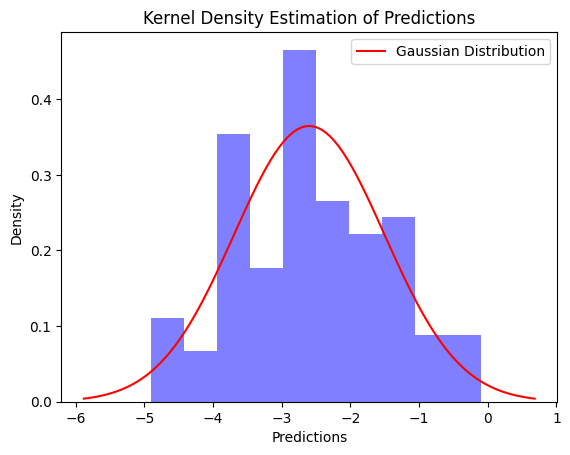

In [67]:
plt.figure()
# Plot kernel density estimation
plt.hist(outlier_free_predictions, bins=10, density=True, alpha=0.5, color='blue')
plt.title('Kernel Density Estimation of Predictions')
plt.xlabel('Predictions')
plt.ylabel('Density')

# Plot gaussian distribution
x = np.linspace(mean - 3*std, mean + 3*std, 100)
y = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)
plt.plot(x, y, color='red', label='Gaussian Distribution')

plt.legend()
plt.show()

In [68]:
from scipy import stats

print(stats.shapiro(outlier_free_predictions))

ShapiroResult(statistic=0.9859634932873585, pvalue=0.4159986001571069)


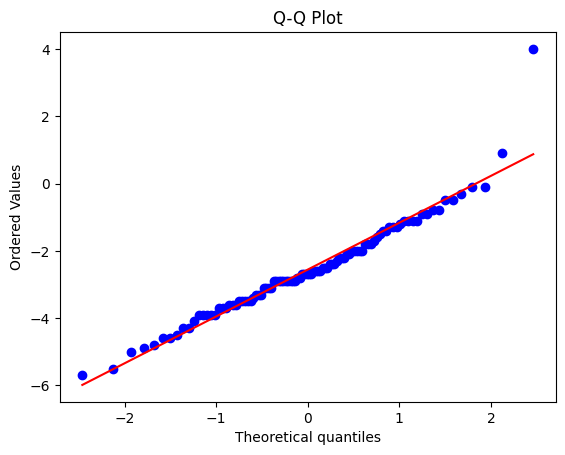

In [65]:
stats.probplot(predictions, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

#### Checking Tokenization

In [ ]:
import requests

# tokenize

url = "http://localhost:8000/tokenize"
headers = {"Content-Type": "application/json"}
data = {
    "model": "Qwen/Qwen2.5-14B",
    "prompt": prompt,
}

response = requests.post(url, headers=headers, json=data).json()

tokens = response["tokens"]

In [20]:

# detokenize

url2 = "http://localhost:8000/detokenize"
headers2 = {"Content-Type": "application/json"}

tokenized_prompt = []

for token in tokens:
    data2 = {
        "model": "Qwen/Qwen2.5-14B",
        "tokens": [token],
    }
    response2 = requests.post(url2, headers=headers2, json=data2).json()
    tokenized_prompt.append(response2["prompt"])


In [21]:
split_prompt_string = "|".join(tokenized_prompt)

#### Plotting

In [61]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
from src.utils import ToyRegressionUtils
from csaps import csaps

from src.utils import calculate_min_Va_by_KL_threshold, calculate_min_Va_by_KL_rank

In [62]:
plt.style.use(['science','no-latex', 'retro', 'grid'])

# Set font size for title
mpl.rcParams['axes.titlesize'] = 26
# Set font size for labels
mpl.rcParams['axes.labelsize'] = 26
# Set font size for tick labels
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams['legend.fontsize'] = 24

In [72]:
results_directory = 'results/linear_regression_1/experiment_3/'

shots = 15

In [64]:
# Load the results
df_list = []
for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"results_" in filename:
        save_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        df_list.append(save_data)

In [65]:
D_data = None

for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"D_" in filename:
        D_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        

In [66]:
for save_data in df_list:
    # z_data = calculate_min_Va_by_KL_threshold(z_data, threshold=0.005, forward_kl=True)
    save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=5, forward_kl=True, upper_bound_by_total_U=True)
    save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=5, forward_kl=False, upper_bound_by_total_U=True, uncertainty_type="variance")

In [67]:
feature_column = ToyRegressionUtils.get_feature_columns(D_data)[0]

x_x1_list = []
total_uncertainty_list = []
kl_pyx_pyxz_list = []
kl_pyxz_pyx_list = []
min_Va_list = []    
max_Ve_list = []
z_value_for_min_Va_list = []

prob_y_xz_mean_list = []
prob_y_xz_std_list = []
prob_y_x_mean_list = []
prob_y_x_std_list = []
within_threshold_list = []

total_variance_list = []
min_Va_variance_list = []
max_Ve_variance_list = []

for z_df in df_list:
    try:
        x_x1 = z_df[f'x_{feature_column}'].values[0]
        x_x1_list.append(x_x1)
        total_uncertainty = z_df["H[p(y|x,D)]"].values[0]
        total_uncertainty_list.append(total_uncertainty)
        # index where z_value_for_min_Va is True
        min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
        z_value_for_min_Va_list.append(z_df[f"z_{feature_column}"].values[min_Va_index])
        
        # get the prob_y_xz and prob_y_x
        prob_y_x_mean = z_df["p(y|x,D)_mean"].values[min_Va_index]
        prob_y_x_std = z_df["p(y|x,D)_std"].values[min_Va_index]
        prob_y_xz_mean = z_df["p(y|x,z,D)_mean"].values[min_Va_index]
        prob_y_xz_std = z_df["p(y|x,z,D)_std"].values[min_Va_index]
        
        prob_y_x_mean_list.append(prob_y_x_mean)
        prob_y_x_std_list.append(prob_y_x_std)
        prob_y_xz_mean_list.append(prob_y_xz_mean)
        prob_y_xz_std_list.append(prob_y_xz_std)
        
        kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
        kl_pyx_pyxz_list.append(kl_pyx_pyxz)
        kl_pyxz_pyx = z_df["kl_pyxz_pyx"].values[min_Va_index]
        kl_pyxz_pyx_list.append(kl_pyxz_pyx)
        min_Va = z_df["min_Va"].values[0]
        min_Va_list.append(min_Va)
        max_Ve = z_df["max_Ve"].values[0]
        max_Ve_list.append(max_Ve)
        
        within_threshold_list.append(z_df[z_df["within_threshold"]][f"z_{feature_column}"].values)
        
    except:
        pass
    
    try:
        total_variance = z_df["Var[y|x,D]"].values[0]
        total_variance_list.append(total_variance)
        
        min_Va_variance = z_df["min_Va_variance"].values[0]
        min_Va_variance_list.append(min_Va_variance)   
        
        max_Ve_variance = z_df["max_Ve_variance"].values[0]
        max_Ve_variance_list.append(max_Ve_variance)
    except:
        pass     
        
    
# Create a dataframe from the lists
data = {f'x_{feature_column}': x_x1_list,
        'total_uncertainty': total_uncertainty_list,
        'min_Va': min_Va_list,
        'max_Ve': max_Ve_list,
        'kl_pyx_pyxz': kl_pyx_pyxz_list,
        'kl_pyxz_pyx': kl_pyxz_pyx_list,
        'z_value_for_min_Va': z_value_for_min_Va_list,
        'within_threshold': within_threshold_list,
        'prob_y_xz_mean': prob_y_xz_mean_list,
        'prob_y_xz_std': prob_y_xz_std_list,
        'prob_y_x_mean': prob_y_x_mean_list,
        'prob_y_x_std': prob_y_x_std_list,
        }

if len(total_variance_list) > 0:
    data['total_variance'] = total_variance_list
    data['min_Va_variance'] = min_Va_variance_list
    data['max_Ve_variance'] = max_Ve_variance_list

num_Va = len(min_Va_list)

# reduce the length of list to the number of num_Va
for key in data.keys():
    data[key] = data[key][:num_Va]

shots_df = pd.DataFrame(data)

shots_df = shots_df.sort_values(by=f'x_{feature_column}')

In [70]:
# Remove min_Va if it is -inf

shots_df = shots_df[(shots_df["min_Va"] != -np.inf)]

     x_x1  total_uncertainty   min_Va   max_Ve  kl_pyx_pyxz  kl_pyxz_pyx  \
66  -14.8            3.28921  2.08357  1.20564     1.187558    11.928011   
88  -14.2            3.42718  1.83949  1.58769     0.160631     0.236905   
114 -12.8            3.70349  1.96135  1.74214     0.357880     0.972648   
61  -12.6            3.45071  2.25031  1.20040     0.554424     2.098015   
113 -12.0            3.32036  2.08357  1.23679     1.333076    16.442572   
..    ...                ...      ...      ...          ...          ...   
10    7.4            2.71489  2.02089  0.69400     0.057633     0.081642   
91    7.6            2.10041  1.83964  0.26077     0.042355     0.056544   
83    7.8            2.37133  1.82264  0.54869     0.307496     0.714779   
95    8.0            3.39387  1.83080  1.56307     1.155821     0.411706   
9     8.2            2.68358  2.03480  0.64878     0.347573     0.436901   

     z_value_for_min_Va                     within_threshold  prob_y_xz_mean  \
66     

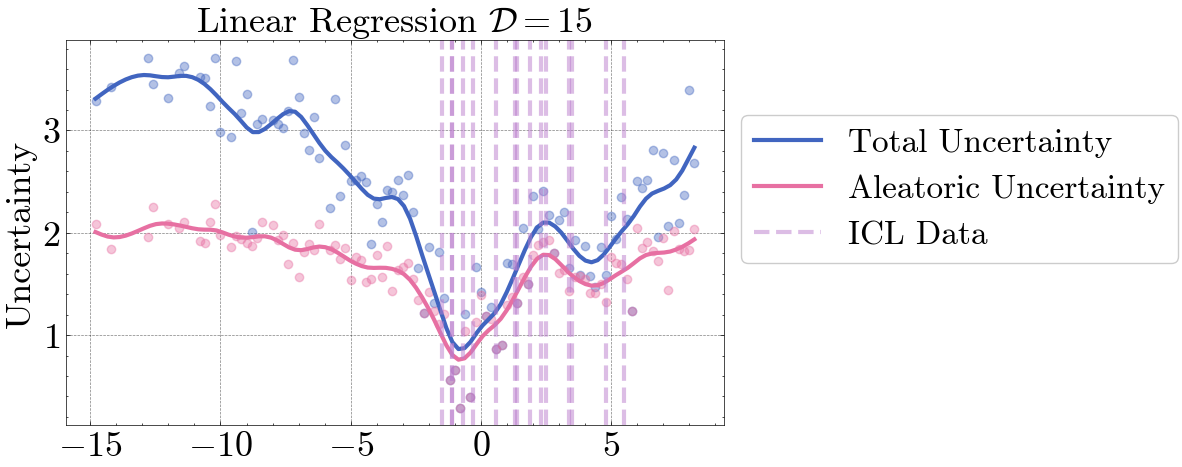

In [92]:
# plot x vs total uncertainty and min Va
# with csaps smoothing

plt.figure(figsize=(8.5, 5))

print(shots_df)

x_grid = np.linspace(shots_df[f'x_{feature_column}'].min(), shots_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty = csaps(shots_df[f'x_{feature_column}'], shots_df['total_uncertainty'], smooth=0.85)
y_min_Va = csaps(shots_df[f'x_{feature_column}'], shots_df['min_Va'], smooth=0.85)

plt.scatter(shots_df[f'x_{feature_column}'], shots_df['total_uncertainty'], color='C0', alpha=0.4)
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['min_Va'], color = 'C1', alpha=0.4)
plt.plot(x_grid, y_total_uncertainty(x_grid), color='C0', linewidth=3, label='Total Uncertainty')
plt.plot(x_grid, y_min_Va(x_grid), color='C1', linewidth=3, label='Aleatoric Uncertainty')

# vertical line for the true x
label_seen = False
for i, row in D_data.iterrows():
    if not label_seen:
        label_seen = True
        label_string = 'ICL Data'
    else:
        label_string = None
    plt.axvline(x=row[feature_column], color='C5', linestyle='--', alpha=0.5, linewidth=3, label=label_string)
plt.title(rf"Linear Regression $\mathcal{{D}} = {shots}$")

# if x value is at most 0.1 away from an icl value plot total uncertainty with a red colour
# icl_x1 = D_data[feature_column].values
# for i, row in shots_df.iterrows():
#     for j, icl_value in enumerate(icl_x1):
#         if abs(row[f'x_{feature_column}'] - icl_value) <= 0.15:
#             plt.scatter(row[f'x_{feature_column}'], row['total_uncertainty'], color='red')
#             break

# plt.yscale('log')

# horizontal line for the true aleotoric uncertainty
true_lower_std = 2
lower_entropy = 0.5 * np.log(2 * np.pi * np.e * true_lower_std**2)
# plt.axhline(y=lower_entropy, color='C1', linestyle='--', alpha=0.5, linewidth=3, label='True Aleotoric Uncertainty') 

# true_upper_std = 2
# upper_entropy = 0.5 * np.log(2 * np.pi * np.e * true_upper_std**2)
# plt.axhline(y=upper_entropy, color='r', linestyle='--', alpha=0.5, label='true upper aleotoric uncertainty')
plt.legend(bbox_to_anchor=(1, 0.85))

plt.ylabel('Uncertainty')
plt.show()

     x_x1  total_uncertainty   min_Va   max_Ve  kl_pyx_pyxz  kl_pyxz_pyx  \
66  -14.8            3.28921  2.08357  1.20564     1.187558    11.928011   
88  -14.2            3.42718  1.83949  1.58769     0.160631     0.236905   
114 -12.8            3.70349  1.96135  1.74214     0.357880     0.972648   
61  -12.6            3.45071  2.25031  1.20040     0.554424     2.098015   
113 -12.0            3.32036  2.08357  1.23679     1.333076    16.442572   
..    ...                ...      ...      ...          ...          ...   
10    7.4            2.71489  2.02089  0.69400     0.057633     0.081642   
91    7.6            2.10041  1.83964  0.26077     0.042355     0.056544   
83    7.8            2.37133  1.82264  0.54869     0.307496     0.714779   
95    8.0            3.39387  1.83080  1.56307     1.155821     0.411706   
9     8.2            2.68358  2.03480  0.64878     0.347573     0.436901   

     z_value_for_min_Va                     within_threshold  prob_y_xz_mean  \
66     

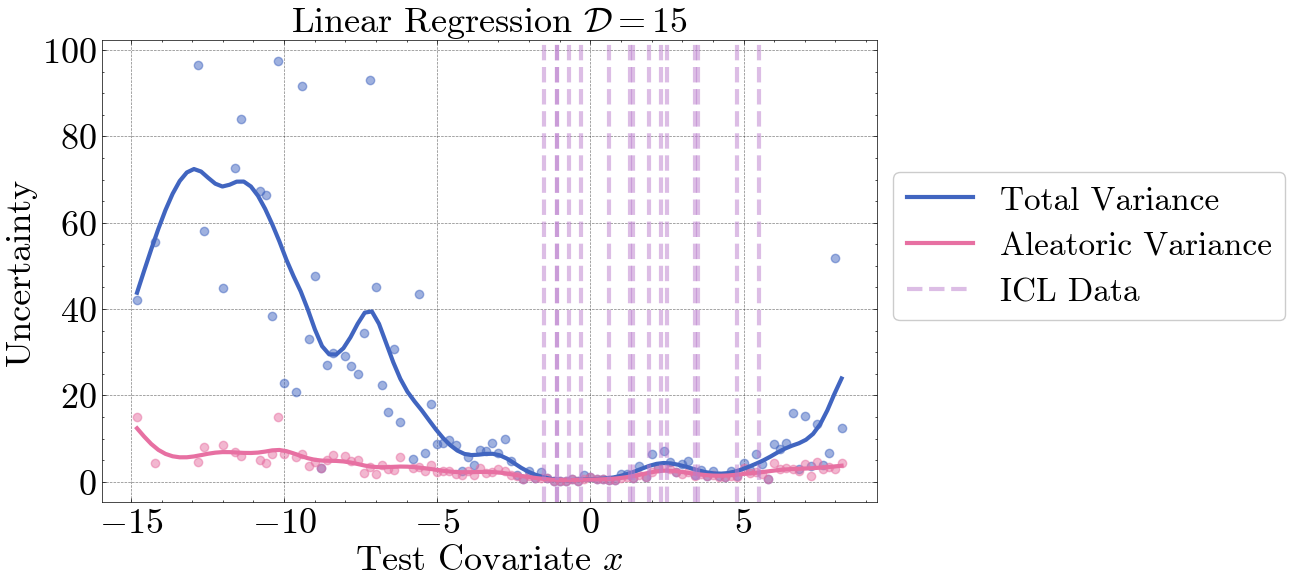

In [ ]:
# plot x vs total uncertainty and min Va
# with csaps smoothing

plt.figure(figsize=(10, 6))

print(shots_df)

x_grid = np.linspace(shots_df[f'x_{feature_column}'].min(), shots_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty = csaps(shots_df[f'x_{feature_column}'], shots_df['total_variance'], smooth=0.85)
y_min_Va = csaps(shots_df[f'x_{feature_column}'], shots_df['min_Va_variance'], smooth=0.85)

plt.scatter(shots_df[f'x_{feature_column}'], shots_df['total_variance'], color='C0', alpha=0.5)
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['min_Va_variance'], color='C1', alpha=0.5)
plt.plot(x_grid, y_total_uncertainty(x_grid), color='C0', linewidth=3, label='Total Variance')
plt.plot(x_grid, y_min_Va(x_grid), color='C1', linewidth=3, label='Aleatoric Variance')

# vertical line for the true x
label_seen = False
for i, row in D_data.iterrows():
    if not label_seen:
        label_seen = True
        label_string = 'ICL Data'
    else:
        label_string = None
    plt.axvline(x=row[feature_column], color='C5', linestyle='--', alpha=0.5, linewidth=3, label=label_string)
plt.title(rf"Linear Regression $\mathcal{{D}} = {shots}$")

# if x value is at most 0.1 away from an icl value plot total uncertainty with a red colour
# icl_x1 = D_data[feature_column].values
# for i, row in shots_df.iterrows():
#     for j, icl_value in enumerate(icl_x1):
#         if abs(row[f'x_{feature_column}'] - icl_value) <= 0.15:
#             plt.scatter(row[f'x_{feature_column}'], row['total_uncertainty'], color='red')
#             break

plt.yscale('log')
plt.ylabel('Uncertainty')


# horizontal line for the true aleotoric uncertainty
true_lower_std = 2
# plt.axhline(y=true_lower_std**2, color='r', linestyle='--', alpha=0.5, label='True Aleatoric Uncertainty') 
plt.legend(bbox_to_anchor=(1, 0.75))

# true_upper_std = 2
# plt.axhline(y=true_upper_std**2, color='r', linestyle='--', alpha=0.5, label='true upper aleatoric uncertainty')

plt.xlabel(r'Test Covariate $x$')
plt.show()

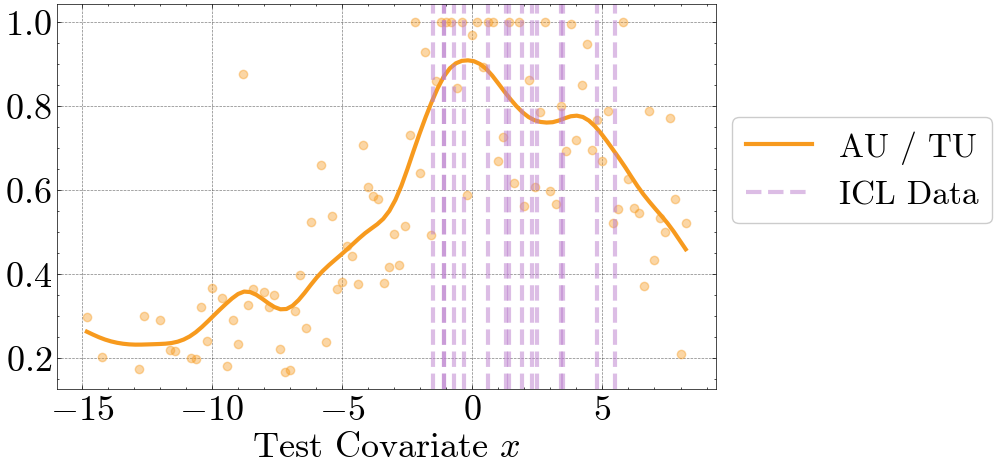

In [ ]:
# min Va total uncertainty ratio

shots_df['min_Va_total_uncertainty_ratio'] = np.exp(shots_df['min_Va'] - shots_df['total_uncertainty'])

x_grid = np.linspace(shots_df[f'x_{feature_column}'].min(), shots_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty_ratio = csaps(shots_df[f'x_{feature_column}'], shots_df['min_Va_total_uncertainty_ratio'], smooth=0.5)

plt.figure(figsize=(8.5, 5))
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['min_Va_total_uncertainty_ratio'], color='C4', alpha=0.4)
plt.plot(x_grid, y_total_uncertainty_ratio(x_grid), linewidth=3, color='C4', label='AU / TU')

# vertical line for the true x
label_seen = False
for i, row in D_data.iterrows():
    if not label_seen:
        label_seen = True
        label_string = 'ICL Data'
    else:
        label_string = None
    plt.axvline(x=row[feature_column], color='C5', linestyle='--', alpha=0.5, linewidth=3, label=label_string)

plt.legend(bbox_to_anchor=(1, 0.75))
plt.xlabel(r'Test Covariate $x$')

# if x value is at most 0.1 away from an icl value plot total uncertainty with a red colour
# icl_x1 = D_data[feature_column].values
# for i, row in shots_df.iterrows():
#     for j, icl_value in enumerate(icl_x1):
#         if abs(row[f'x_{feature_column}'] - icl_value) <= 0.15:
#             plt.scatter(row[f'x_{feature_column}'], row['min_Va_total_uncertainty_ratio'], color='red')
#             break
plt.show()

Text(0.5, 1.0, 'mean and std of prob_y_x')

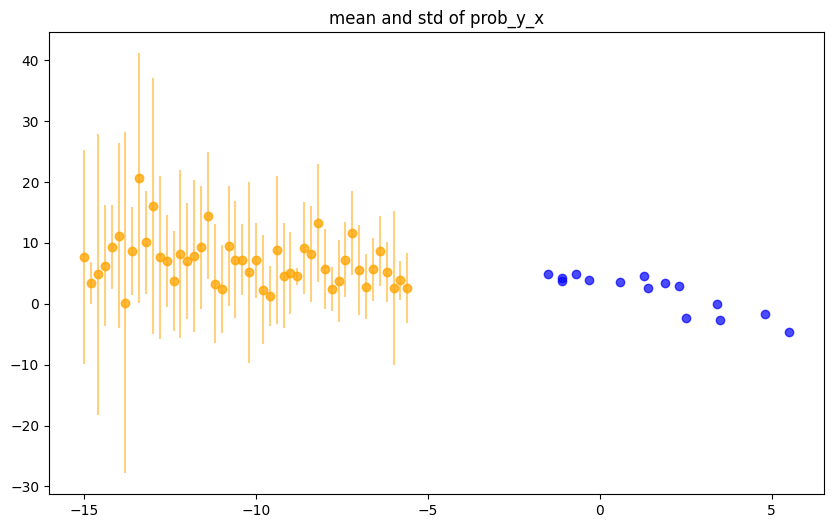

In [30]:
# plot mean of prob_y_x with std error 

plt.figure(figsize=(10, 6))
plt.scatter(shots_df[f'x_{feature_column}'], shots_df['prob_y_x_mean'], label='mean of prob_y_x', color='orange', alpha=0.5)
plt.errorbar(shots_df[f'x_{feature_column}'], shots_df['prob_y_x_mean'], yerr=shots_df['prob_y_x_std'], fmt='o', color='orange', alpha=0.5, label='std of prob_y_x')

# scatter plot for D
for i, row in D_data.iterrows():
    plt.scatter(row[feature_column], row['label'], color='b', alpha=0.7)
plt.title(f"mean and std of prob_y_x")
